<a href="https://colab.research.google.com/github/manikcb/all-my-assignments/blob/main/adaboost%20histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
# from logistic import Logistic_Regression

In [ ]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [ ]:
from sklearn.base import BaseEstimator


class Logistic_Regression(BaseEstimator):
    
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.cost_per_iteration = []
        
    
    def _sigmoid(self, x):
        EPS = 1e-7
        return 1 / (1 + np.exp(-x + EPS))
    
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        
        # gradient descent

        for _ in range(self.epochs):
            # forward propagation
            Z = np.dot(X, self.weights) + self.bias
            A = self._sigmoid(Z)
            
            # backward propagation
            dw = (1 / m) * np.dot(X.T, A - y)
            db = (1 / m) * np.sum(A - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(Z)
    
        if not isinstance(A, float):
            y_predicted_cls = [1 if i >= 0.5 else 0 for i in A]
        else:
            y_predicted_cls = 1 if A >= 0.5 else 0
        return y_predicted_cls
    
    
    def __str__(self):
        return f"Logistic_Regression(learning_rate={self.learning_rate}, epochs={self.epochs})"

In [ ]:
class AdaBoost(object):
    
    def __init__(self, base_estimator, n_estimators, learning_rate):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.predictor_weightages = []
        
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):

            # initially all instances have the same weight
            instance_weights = self._initial_instance_weights(n_samples)
            
            # Use predictor to make classification error
            clone_clf = clone(self.base_estimator)
            clone_clf.fit(X, y)
            predicted = clone_clf.predict(X)
            
            # getting misclassified instances
            mis_classified_instances, acc = self._getAccuracy(y, predicted)
            
            # total error made by the predictor
            total_err = self._total_error(mis_classified_instances, instance_weights)
            
            # weightage of predictor based on its error
            predictor_weightage = self._get_predictor_weightage(total_err)
            self.predictor_weightages.append((i, clone_clf, predictor_weightage))
            
            # updating instance weights
            instance_weights = self._update_instance_weights(mis_classified_instances, 
                                                             instance_weights, predictor_weightage)

            
            # sampling data with replacement focusing on instances that were misclassified
            X, y = self._new_sample_set(X, y, instance_weights)

    

    def _initial_instance_weights(self, shape):
        instance_weights = np.full(shape=shape, fill_value=1/shape)
        return instance_weights
    
    
    def _getAccuracy(self, true, predicted):
        assert len(true) == len(predicted)
        error_instance = np.equal(true, predicted).astype(int)
        miss_classified = []

        for i, j in enumerate(error_instance):
            if j == 0:
                miss_classified.append(i)
                
        accuracy = np.sum(true == predicted)
        return miss_classified, (accuracy/len(true)) * 100.0
    
    
    def _total_error(self, mis_classified, instance_weights):
        error = 0
        for i in mis_classified:
            error += instance_weights[i]

        return error
    
    def _get_predictor_weightage(self, error):
        EPS = 1e-5
        weightage = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))
        return weightage

    
    def _update_instance_weights(self, mis_classified_instances, instance_weights, predictor_weightage):
        weights = instance_weights[:]
        EPS = 1e-10
        for idx in range(len(instance_weights)):
            if idx in mis_classified_instances:
                weights[idx] = weights[idx] * np.exp(predictor_weightage + EPS)
            else:
                weights[idx] = weights[idx] * np.exp(-predictor_weightage + EPS)


        # Normalizing weights
        summed_weights = np.sum(weights)
        weights /= summed_weights
        return np.array(weights)
    
    def _new_sample_set(self, X, y, instance_weights):
        intervals = []
        intervals.append(instance_weights[0])

        for i, j in enumerate(instance_weights[1:], 1):
            intervals.append(j + intervals[i-1])

        idxs = []

        for i in range(X.shape[0]):
            samp = np.random.sample()
            try:
                idx = np.searchsorted(intervals, samp, side='right')
                _ = X[idx] # check if exists
            except:
                idx = idx - 1

            finally:
                idxs.append(idx)

        X = X[idxs]
        y = y[idxs]
        return X, y
    
    def predict(self, X):
        clf_predictions = np.array([clf.predict(X) for idx, clf, weightage in self.predictor_weightages])
        predictions = []
        
        for sample_predictions in clf_predictions.T:
            class_0 = 0
            class_1 = 0
            
            for predictor, predictor_op in enumerate(sample_predictions):
                if predictor_op == 0:
                    class_0 += self.predictor_weightages[predictor][2]
                else:
                    class_1 += self.predictor_weightages[predictor][2]
            
            if class_0 > class_1:
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)

In [14]:
df= pd.read_csv(r'/content/DATABASE-KERATOCONUS.csv')
df=df.drop(columns=['Grado QC','Grado QC','Esfera','Cilindro','COMA ANT 90','COMA CORNEA 0','TREFOIL 0º','TETRAFOIL 0º'])
df.head()

,ID,Edad,Sexo,Ojo,AVSC,Eje,AVCC,EQ. ESF,K1,K1 Eje,...,Astigm 2º CORNEA 0º,Astigm 2º CORNEA 45º,COMA ANT 0,COMA POST 0,COMA POST 90,COMA CORNEA 90,TREFOIL 30º,"TETRAFOIL 22,5º",ABERR. ESF,FECHA
0,1001,24,H,OD,0.05,30.0,1.0,-6.0,42.6,36.7,...,-0.713,-1.739,0.002,-0.026,-0.027,-0.429,0.038,0.122,0.253,4/24/2018
1,1002,24,H,OI,0.1,170.0,1.0,-6.0,42.0,165.8,...,-2.599,1.325,-0.005,0.039,-0.055,0.191,-0.047,-0.047,0.201,4/24/2018
2,1003,20,H,OD,0.15,5.0,0.8,-2.0,41.7,1.9,...,-6.034,-0.564,-0.144,0.002,-0.026,0.113,-0.037,0.035,-0.085,6/26/2018
3,1004,20,H,OI,0.1,170.0,0.9,-2.0,41.5,169.5,...,-5.523,2.264,0.222,0.015,-0.065,-0.006,0.190,0.040,-0.068,6/26/2018
4,1005,23,M,OD,1,NaN,1.0,NaN,41.9,7.5,...,-0.810,-0.252,-0.307,0.039,0.024,-0.129,0.158,-0.138,0.131,1/22/2019


In [7]:
df=pd.get_dummies(df, columns=['K','Status'])
df.head(10)

KeyError: ignored

In [8]:
y = df['Status_H']
X=df.drop(columns=['Status_M','K_H','K_M'])


KeyError: ignored

In [ ]:
df.head()

,Edad,K1,K1 Eje,K2,K2 Eje,Km,KMAX,Q,IVA,K1.1,...,COMA CORNEA 90,TREFOIL 0º,TREFOIL 30º,TETRAFOIL 0º,"TETRAFOIL 22,5º",ABERR. ESF,K_H,K_M,Status_H,Status_M
0,24,42.6,36.7,44.6,126.7,43.6,45.3,-0.17,0.14,-5.9,...,-0.429,0.110,0.038,-0.035,0.122,0.253,1,0,1,0
1,24,42.0,165.8,45.1,75.8,43.5,45.4,-0.27,0.07,-5.8,...,0.191,0.080,-0.047,-0.029,-0.047,0.201,1,0,1,0
2,20,41.7,1.9,48.3,91.9,44.7,50.4,-0.50,0.18,-5.9,...,0.113,-0.091,-0.037,-0.292,0.035,-0.085,1,0,1,0
3,20,41.5,169.5,48.1,79.5,44.5,49.5,-0.52,0.17,-5.9,...,-0.006,0.093,0.190,-0.165,0.040,-0.068,1,0,1,0
4,23,41.9,7.5,42.9,97.5,42.4,43.4,-0.36,0.21,-6.2,...,-0.129,0.050,0.158,-0.104,-0.138,0.131,0,1,0,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

NameError: ignored

In [10]:
ada_clf = AdaBoost(base_estimator=Logistic_Regression(learning_rate=0.001, epochs=500),
                  n_estimators=10, learning_rate=0.5)

NameError: ignored

In [12]:
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_train)
print(f"Training Accuracy: {round(accuracy(y_train, y_test), 2)}")

y_pred = ada_clf.predict(X_test)
print(f"Validation Accuracy: {round(accuracy(y_test, y_test), 2)}")

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


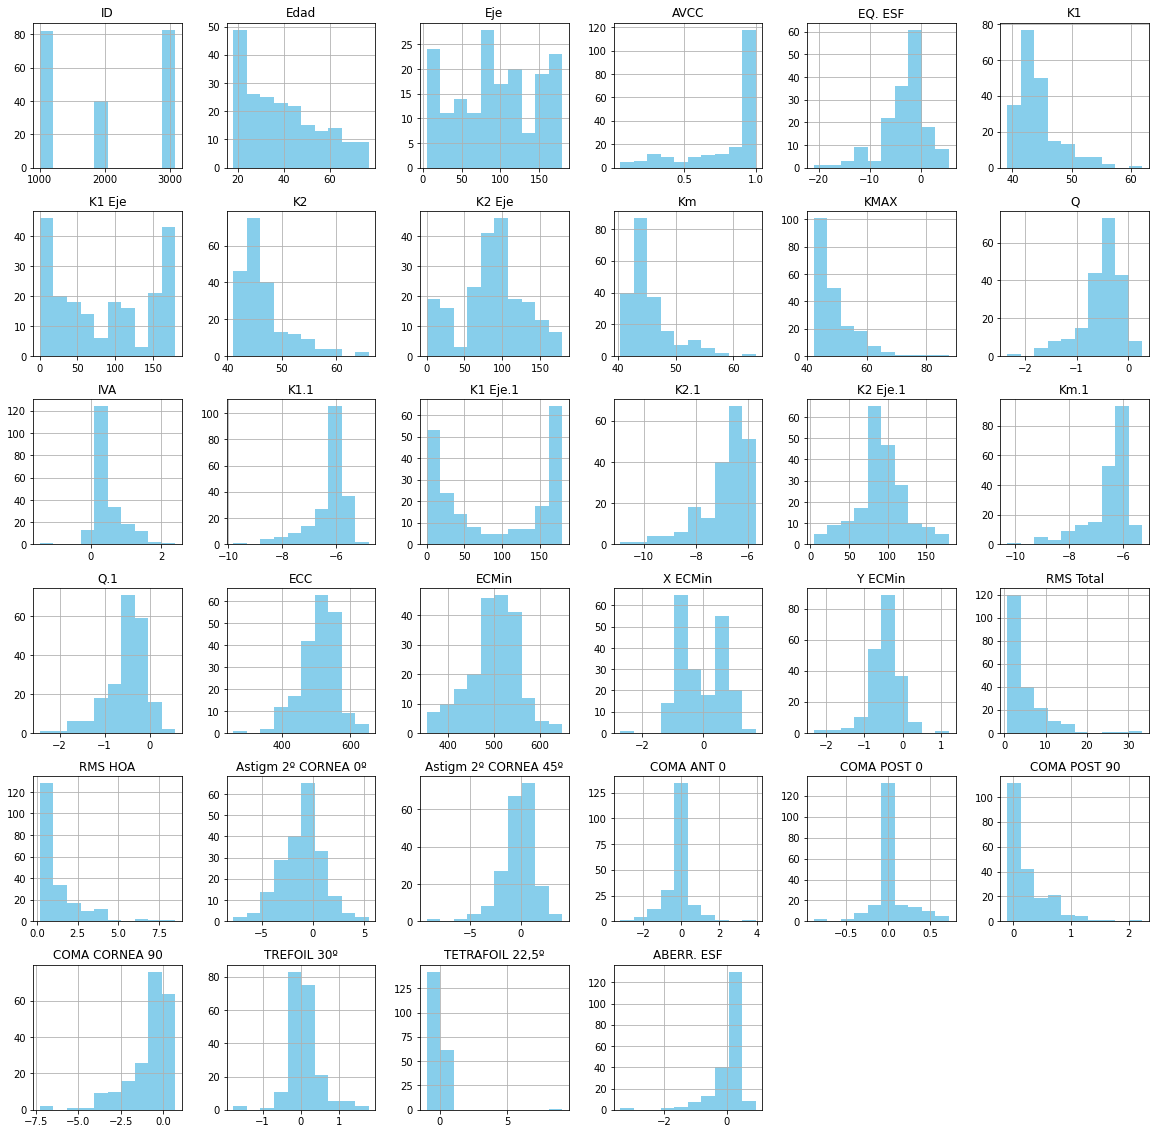

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df.hist(ax=ax, color = "skyblue")
plt.show()